In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import copy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
titanic_train = pd.read_csv('data/train.csv')
titanic_test = pd.read_csv('data/test.csv')

In [3]:
titanic_train.describe

<bound method NDFrame.describe of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                 

In [4]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Step 1: dropping columns that have no affect on the data 'mostly non numerical data'

here we dropped the following columns:
- PassengerId
- Ticket
- Name
- SibSp
- Parch
- Ticket
- Cabin
- Embarked
- Fare

In [6]:
titanic_train.drop(columns=['PassengerId','Ticket','Name','SibSp','Parch','Ticket','Cabin','Embarked','Fare'], inplace=True)

binning the attribute 'Sex' into (0,1)
- male : 0
- female : 1

In [7]:
titanic_train['Sex'] = titanic_train['Sex'].map({'male':0, 'female':1})

replacing the missing values in the attribute 'Age' with the median

In [8]:
titanic_train['Age'].fillna(titanic_train.Age.median(), inplace=True)

/tmp/ipykernel_18956/2685060518.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_train['Age'].fillna(titanic_train.Age.median(), inplace=True)


In [9]:
titanic_train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
dtype: int64

our final train dataset after the previous changes

In [10]:
titanic_train

,Survived,Pclass,Sex,Age
0,0,3,0,22.0
1,1,1,1,38.0
2,1,3,1,26.0
3,1,1,1,35.0
4,0,3,0,35.0
...,...,...,...,...
886,0,2,0,27.0
887,1,1,1,19.0
888,0,3,1,28.0
889,1,1,0,26.0


### Step 2: Selection of Features

selecting the attributes on which we want to apply the selection features

In [11]:
numeric_columns = ['Pclass', 'Sex', 'Age']

##### plot before scaling

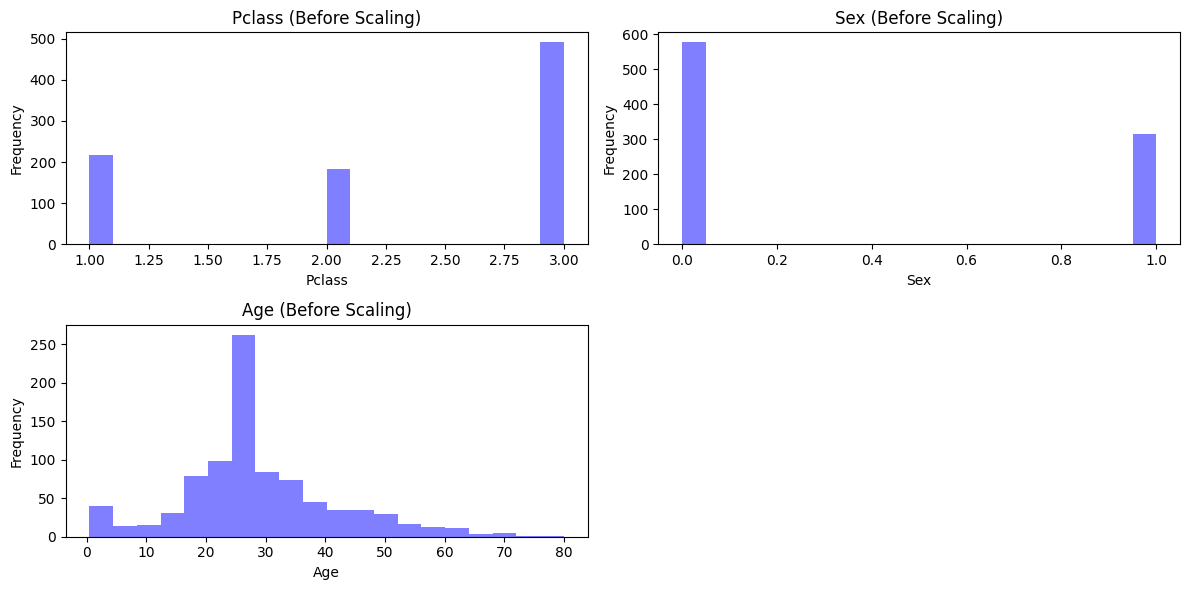

In [12]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    plt.hist(titanic_train[feature].dropna(), bins=20, color='blue', alpha=0.5)
    plt.title(f'{feature} (Before Scaling)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

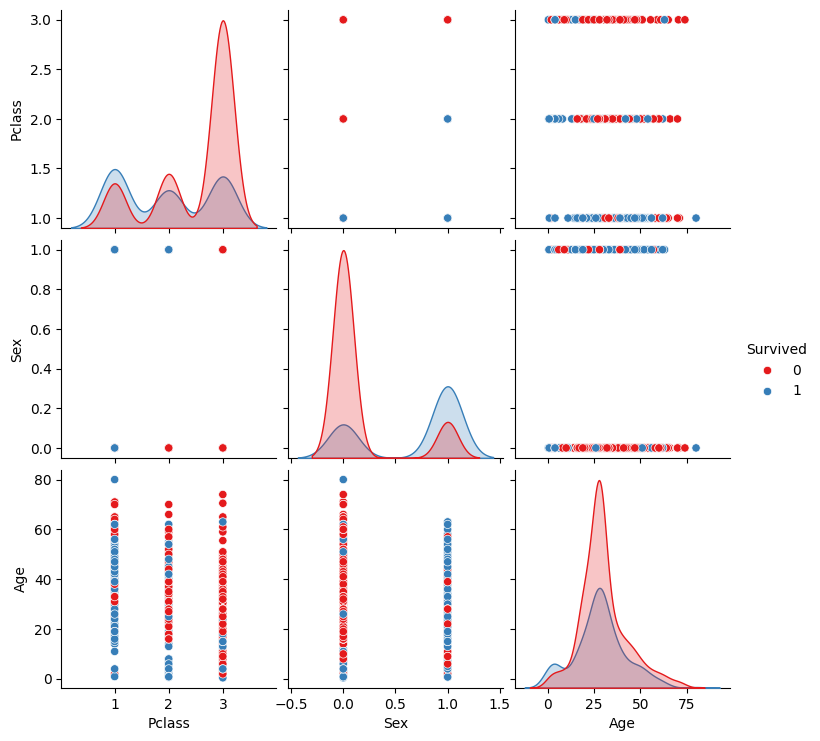

In [13]:
selected_features_with_embarked = pd.concat([titanic_train[numeric_columns], titanic_train['Survived']], axis=1)

sns.pairplot(selected_features_with_embarked, hue='Survived', palette='Set1')
plt.show()

#### Step 2.1: Scaling

##### Normalization
we used the MinMaxScaler for Normalization from the 'sklearn.preprocessing' library to rescale the data to a specefic range

In [14]:
titanic_train_copy_norm = copy.deepcopy(titanic_train)
titanic_test_copy_norm = copy.deepcopy(titanic_test)

norm_scaler = MinMaxScaler()
titanic_train_copy_norm[numeric_columns] = norm_scaler.fit_transform(titanic_train_copy_norm[numeric_columns])

titanic_train_copy_norm

,Survived,Pclass,Sex,Age
0,0,1.0,0.0,0.271174
1,1,0.0,1.0,0.472229
2,1,1.0,1.0,0.321438
3,1,0.0,1.0,0.434531
4,0,1.0,0.0,0.434531
...,...,...,...,...
886,0,0.5,0.0,0.334004
887,1,0.0,1.0,0.233476
888,0,1.0,1.0,0.346569
889,1,0.0,0.0,0.321438


In [15]:
np.round(titanic_train_copy_norm.describe(),1)

,Survived,Pclass,Sex,Age
count,891.0,891.0,891.0,891.0
mean,0.4,0.7,0.4,0.4
std,0.5,0.4,0.5,0.2
min,0.0,0.0,0.0,0.0
25%,0.0,0.5,0.0,0.3
50%,0.0,1.0,0.0,0.3
75%,1.0,1.0,1.0,0.4
max,1.0,1.0,1.0,1.0


#####  Standardization
we used the StandardScaler for Standardization from the 'sklearn.preprocessing' library to rescale the data to a specefic range

In [16]:
titanic_train_copy_std = copy.deepcopy(titanic_train)
titanic_test_copy_std = copy.deepcopy(titanic_test)


scaler_std = StandardScaler()
titanic_train_copy_std[numeric_columns] = scaler_std.fit_transform(titanic_train_copy_std[numeric_columns])

titanic_train_copy_std

,Survived,Pclass,Sex,Age
0,0,0.827377,-0.737695,-0.565736
1,1,-1.566107,1.355574,0.663861
2,1,0.827377,1.355574,-0.258337
3,1,-1.566107,1.355574,0.433312
4,0,0.827377,-0.737695,0.433312
...,...,...,...,...
886,0,-0.369365,-0.737695,-0.181487
887,1,-1.566107,1.355574,-0.796286
888,0,0.827377,1.355574,-0.104637
889,1,-1.566107,-0.737695,-0.258337


In [17]:
np.round(titanic_train_copy_std.describe(),1)

,Survived,Pclass,Sex,Age
count,891.0,891.0,891.0,891.0
mean,0.4,-0.0,0.0,0.0
std,0.5,1.0,1.0,1.0
min,0.0,-1.6,-0.7,-2.2
25%,0.0,-0.4,-0.7,-0.6
50%,0.0,0.8,-0.7,-0.1
75%,1.0,0.8,1.4,0.4
max,1.0,0.8,1.4,3.9
